# Tutorial

Setting matplotlib formats for tutorials.  
Please skip the next cell.

In [1]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

Import CAPITAL and Scanpy.

In [2]:
%matplotlib inline
import capital as cp
import scanpy as sc

## Preprocessing scRNA-seq data
Read a count matrix (cells x genes) of your own data as an AnnData object using sc.read().

In [3]:
#adata1 = sc.read("./your_data1.h5ad")

Run a simple preproccesing recipe.

In [4]:
#cp.tl.preprocessing(adata1, n_Top_genes=2000, K=40)

Specifically, cp.tl.preprocessing() runs a simple preprocessing recipe as follows:

```
sc.pp.filter_cells(adata, min_genes=Min_Genes)
sc.pp.filter_genes(adata, min_cells=Min_Cells)
sc.pp.normalize_total(adata, exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=Min_Mean, max_mean=Max_Mean, min_disp=Min_Disp, n_top_genes=n_Top_genes)
adata.raw = adata
adata = adata[:,adata.var['highly_variable']]
sc.tl.pca(adata, n_comps=N_pcs)
sc.pp.neighbors(adata, n_neighbors=K, n_pcs=N_pcs)
sc.tl.diffmap(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.tl.paga(adata, groups='leiden')
```

In this tutorial, we will use two datasets that have already been preprocessed.  
Download might take a minute.

In [5]:
adata1 = cp.dataset.setty19()

The dataset already exist in ../data/capital_dataset/setty19_capital.h5ad.
Reading datasets from ../data/capital_dataset/setty19_capital.h5ad.


In [6]:
adata1

AnnData object with n_obs × n_vars = 5780 × 1999
    obs: 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

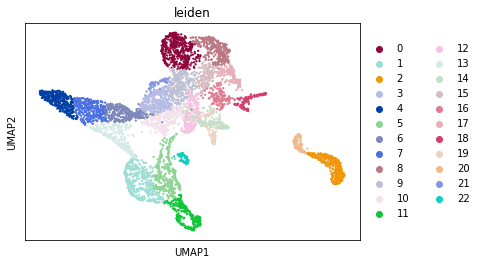

In [7]:
sc.pl.umap(adata1, color="leiden")

Note that dataset 2 will be loaded later.

## Computing a trajectory tree with CAPITAL
Pass the AnnData object and the root name in the trajectory tree to cp.tl.trajectory_tree().  
You can pass your metadata in adata.obs by choosing a key in adata.obs.  
You can also draw your own defined tree in networkx.DiGraph and pass it to the argument.

In [8]:
cp.tl.trajectory_tree(adata1, root_node="4", groupby="leiden", tree=None)

Draw the calculated tree.

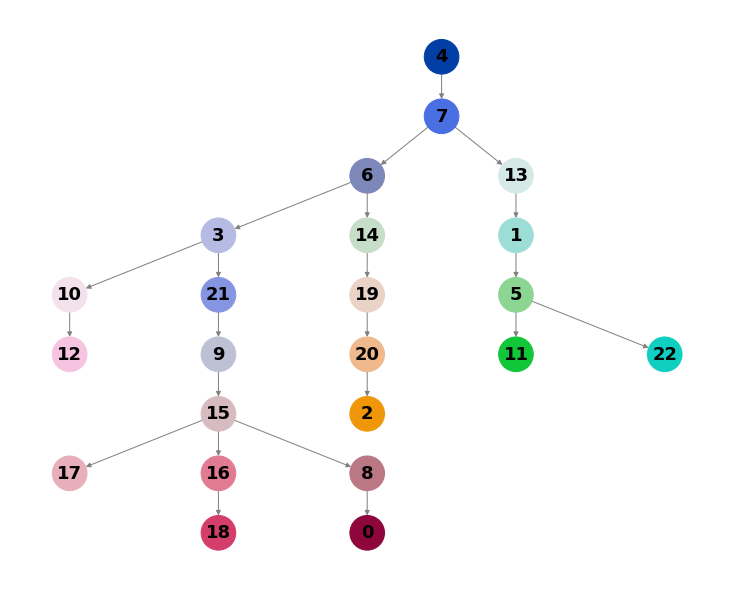

In [9]:
cp.pl.trajectory_tree(adata1)

Apply the same process to one or more datasets that you would like to align.

In [10]:
adata2 = cp.dataset.velten17()

The dataset already exist in ../data/capital_dataset/velten17_capital.h5ad.
Reading datasets from ../data/capital_dataset/velten17_capital.h5ad.


In [11]:
adata2

AnnData object with n_obs × n_vars = 915 × 249
    obs: 'n_genes', 'n_counts', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

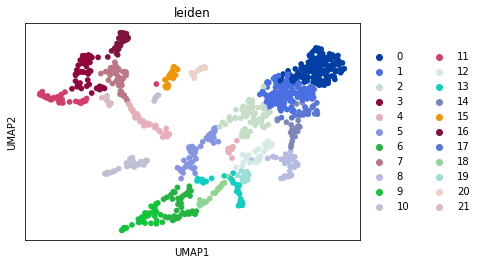

In [12]:
sc.pl.umap(adata2, color="leiden")

In [13]:
cp.tl.trajectory_tree(adata2, root_node="0", groupby="leiden", tree=None)

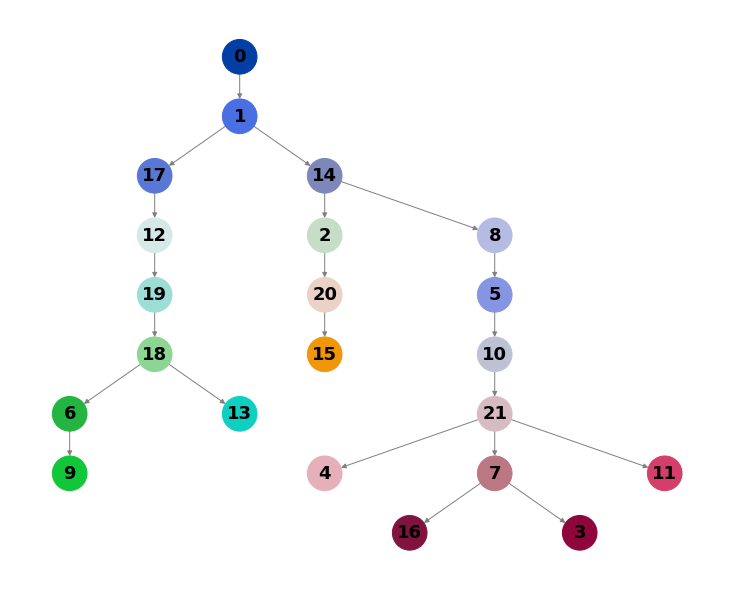

In [14]:
cp.pl.trajectory_tree(adata2)

## Aligning trajectory trees with CAPITAL
The alignment of trajectory trees is calculated by minimizing an alignment distance.
<!--
described in [our paper](https://www.biorxiv.org/content/10.1101/859751v1).
-->
You can specify the number of highly variable genes for both of the data so that the intersection of those genes is used to calculate the tree alignment.

In [15]:
cdata = cp.tl.tree_alignment(adata1, adata2, num_genes1=2000, num_genes2=2000)

Calculating tree alignment
411 genes are used to calculate cost of tree alignment.

Calculation finished.


Draw the tree alignment result.

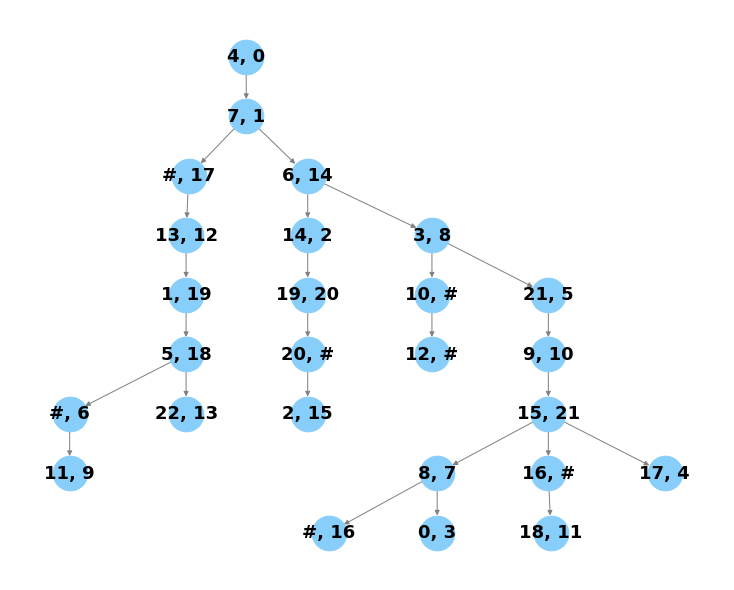

In [16]:
cp.pl.tree_alignment(cdata)

Each linear alignment from the root to each leaf (path) is labeled as alignmentXYZ, where X, Y and Z indicate digit.  
See the list of the alignment name by alignmentlist.

In [17]:
cdata.alignmentlist

[('alignment000',
  ['4', '7', '#', '13', '1', '5', '22'],
  ['0', '1', '17', '12', '19', '18', '13']),
 ('alignment001',
  ['4', '7', '#', '13', '1', '5', '#', '11'],
  ['0', '1', '17', '12', '19', '18', '6', '9']),
 ('alignment002',
  ['4', '7', '6', '14', '19', '20', '2'],
  ['0', '1', '14', '2', '20', '#', '15']),
 ('alignment003',
  ['4', '7', '6', '3', '10', '12'],
  ['0', '1', '14', '8', '#', '#']),
 ('alignment004',
  ['4', '7', '6', '3', '21', '9', '15', '8', '#'],
  ['0', '1', '14', '8', '5', '10', '21', '7', '16']),
 ('alignment005',
  ['4', '7', '6', '3', '21', '9', '15', '8', '0'],
  ['0', '1', '14', '8', '5', '10', '21', '7', '3']),
 ('alignment006',
  ['4', '7', '6', '3', '21', '9', '15', '16', '18'],
  ['0', '1', '14', '8', '5', '10', '21', '#', '11']),
 ('alignment007',
  ['4', '7', '6', '3', '21', '9', '15', '17'],
  ['0', '1', '14', '8', '5', '10', '21', '4'])]

## Aligning cells along each linear trajectory path
Run dpt (diffusion pseudotime) to calculate pseudotime for each linear alignment.    
Note: calculating pseudotime for all the alignments might take for a minute.

In [18]:
cp.tl.dpt(cdata)

Run dtw (dynamic time warping) to calculate cell-cell matching.

In [19]:
cp.tl.dtw(cdata, gene=cdata.genes_for_tree_align, multi_genes=True)

Draw the result of dynamic time warping along specified linear alignments.  
The colors in the labels correspond to the colors of sc.pl.umap().

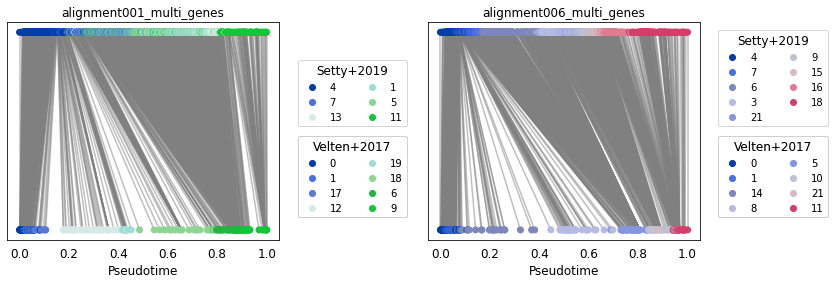

In [20]:
cp.pl.dtw(cdata, gene=["multi_genes"], alignment=["alignment001", "alignment006"], 
          data1_name="Setty+2019", data2_name="Velten+2017")

Draw expression dynamics of specified genes along respective alignments.  

In [21]:
main_markers = [
        ["alignment000", "ITGA2B"],
        ["alignment006", "LGMN"]
     ]

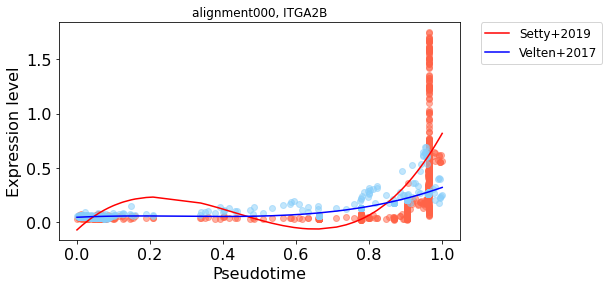

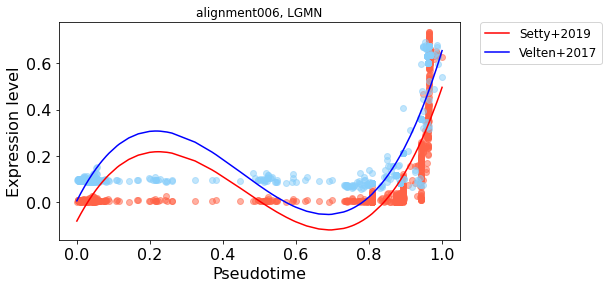

In [22]:
for alignment, gene in main_markers:
    cp.pl.gene_expression_trend(
        cdata, gene=gene, alignment=alignment, fontsize=16, ticksize=16, multi_genes=True, switch_psedotime=True,
        data1_name="Setty+2019", data2_name="Velten+2017", polyfit_dimension=3
    )

## Writing CAPITAL results
Specify a directory so that two AnnData objects, adata1 and adata2, and capital_data.npz are saved in the directory.  
You can read CAPITAL data by passing the directory path to cp.tl.read_capital_data().

In [23]:
cdata.write("../results/cdata")

In [24]:
cdata = cp.tl.read_capital_data("../results/cdata")

## Calculating similarity scores of genes in cell-cell alignment
Computing dynamic time warping will generate a similarity score (see [here](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw_path.html#tslearn.metrics.dtw_path) for details).  
You can pass a value to min_disp to choose how many genes are used to calculate the score.  
The genes that have larger normalized dispersions per gene than min_disp in either data are chosen.  
Results are in cdata.similarity_score.  
The higher the score in the resulting list, the more similar the gene expression trend.

In [25]:
cp.tl.genes_similarity_score(cdata, alignment="alignment002", min_disp=0.5)

Calculating similarity score of 5148 genes in alignment002
Calculating finished


In [26]:
cdata.similarity_score["alignment002"]

array(['HN1', 'WHSC1', 'TROAP', ..., 'ARPP21', 'FCRL1', 'NBEAL1'],
      dtype=object)

See gene expression trends that have similar trends in the alignment.

In [27]:
high_similarlity_genes = cdata.similarity_score["alignment002"][:4]

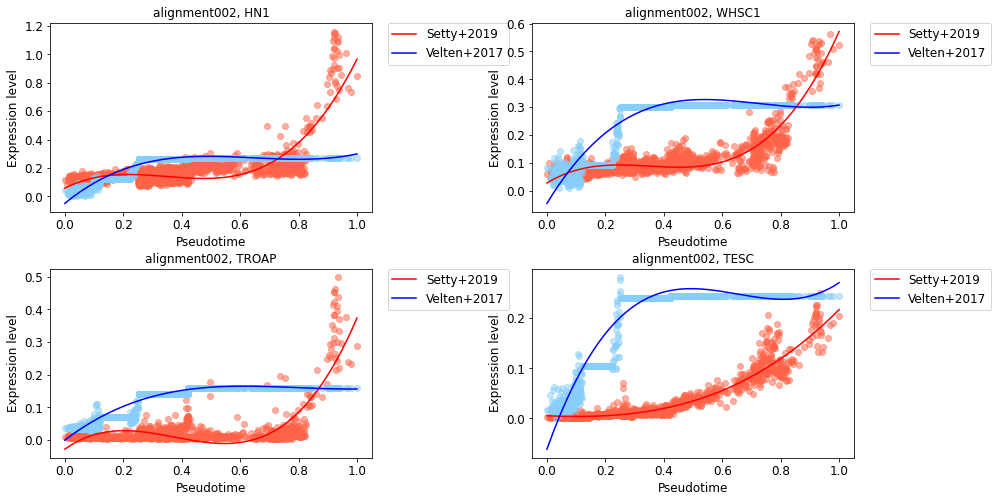

In [28]:
cp.pl.gene_expression_trend(cdata, high_similarlity_genes, alignment="alignment002", 
    data1_name="Setty+2019", data2_name="Velten+2017")

See also gene expression trends that have lower similarity scores in the alignment.

In [29]:
low_similarlity_genes = cdata.similarity_score["alignment002"][::-1][:4]

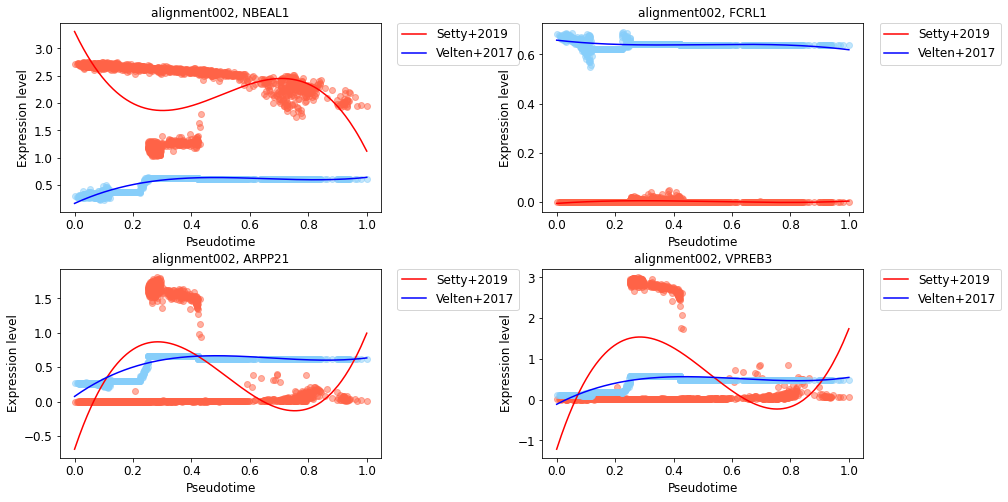

In [30]:
cp.pl.gene_expression_trend(cdata, low_similarlity_genes, alignment="alignment002", 
    data1_name="Setty+2019", data2_name="Velten+2017")